# Opinion Dynamics on a network

Replicates the 3 models presented [here](https://mariuzka.github.io/amp_page/06/amp06b.html), but interactions happen on a network.


In [1]:
import random
from typing import List

import matplotlib.pyplot as plt
import popy as popy
from popy.data_fakers.soep import soep_faker
from popy.pop_maker import PopMaker

In [2]:
class Agent(popy.Agent):
    def __init__(self, model, *args, **kwargs):
        super().__init__(model, *args, **kwargs)

        self.opinion: float = random.random()
        self.opinion_history: List[float] = []
        self.tolerance = self.model.p.tolerance

    def get_weight(self, contact: "Agent", mode: int = 1):
        """Calculates a weight which determines how the opinion of the contact will influence the
        focal agent."""

        # All contacts are weighted the same
        if mode == 1:
            return 1

        # bounded confidence: if the opinion of the contact is too far away from the focal agent's
        # opinion, then the focal agent is not influenced by this opinion
        elif mode == 2:
            abs_opinion_diff = abs(contact.opinion - self.opinion)

            if abs_opinion_diff <= self.tolerance:
                return 1
            else:
                return 0

        # negative influence
        elif mode == 3:
            abs_opinion_diff = abs(contact.opinion - self.opinion)

            if abs_opinion_diff > 0.5:
                return -1 * (2 * abs_opinion_diff - 1)

            else:
                return 1 - 2 * abs_opinion_diff

    def change_opinion(self, mode: int = 1):
        """Simulates the influence of all contacts on the opinion of the focal agent."""

        # get all interaction weights as absolute values and calculate the sum
        sum_of_abs_weights = sum(
            [abs(self.get_weight(contact=agent, mode=mode)) for agent in self.neighbors()],
        )

        # get all weighted differences in opinions between the focal agent and all his contacts
        sum_of_weighted_diffs = sum(
            [
                (agent.opinion - self.opinion) * self.get_weight(contact=agent, mode=mode)
                for agent in self.neighbors()
            ],
        )

        if sum_of_abs_weights != 0 and sum_of_weighted_diffs != 0:
            # calculate opinion change as a weighted average of opinion differences
            opinion_change = sum_of_weighted_diffs / sum_of_abs_weights

            # change opinion
            self.opinion += opinion_change

        # keep the opinion between 0 and 1
        if self.opinion < 0:
            self.opinion = 0
        elif self.opinion > 1:
            self.opinion = 1

    def record_opinion(self):
        """Stores the current opinion value in a list to analyze it after the simulation."""
        self.opinion_history.append(self.opinion)

In [3]:
class Home(popy.Location):
    def group(self, agent):
        return agent.hid


class Work(popy.Location):
    def setup(self):
        self.size = 10

    def join(self, agent):
        return agent.work_hours_day > 0


class School(popy.Location):
    def setup(self):
        self.size = 25

    def join(self, agent) -> bool:
        return 6 <= agent.age <= 18


class All(popy.Location):
    pass

In [4]:
class Model(popy.Model):
    def setup(self):
        # micro-level data
        df_soep = soep_faker.soep(size=self.p.n_agents)

        # PopMaker: creates the population
        self.pop_maker = PopMaker(model=self)

        self.agents, self.locations = self.pop_maker.make(
            df=df_soep,
            agent_class=Agent,
            location_classes=[
                Home,
                Work,
                School,
            ],
        )

    def step(self):
        # select one random agent
        focal_agent = self.agents.random(n=1)

        # execute agent behavior
        focal_agent.change_opinion(mode=self.p.opinion_weight_mode)

    def update(self):
        self.agents.record_opinion()

Completed: 5000 steps
Run time: 0:00:01.450020
Simulation finished


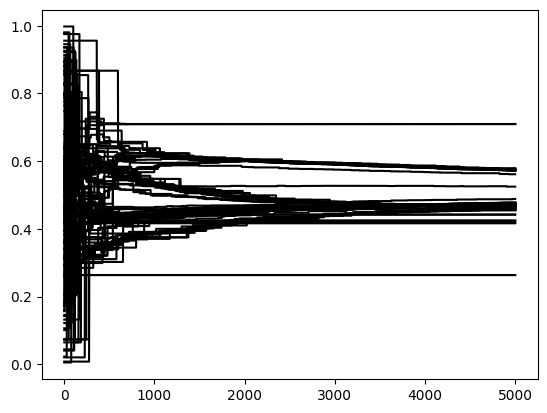

In [5]:
parameters = {
    "steps": 5000,
    "n_agents": 100,
    "opinion_weight_mode": 1,
    "tolerance": 0.3,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")

Completed: 8000 steps
Run time: 0:00:02.944818
Simulation finished


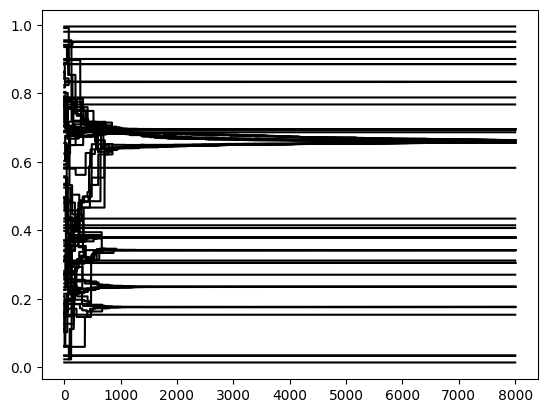

In [6]:
parameters = {
    "steps": 8000,
    "n_agents": 100,
    "opinion_weight_mode": 2,
    "tolerance": 0.2,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")

Completed: 3000 steps
Run time: 0:00:01.111195
Simulation finished


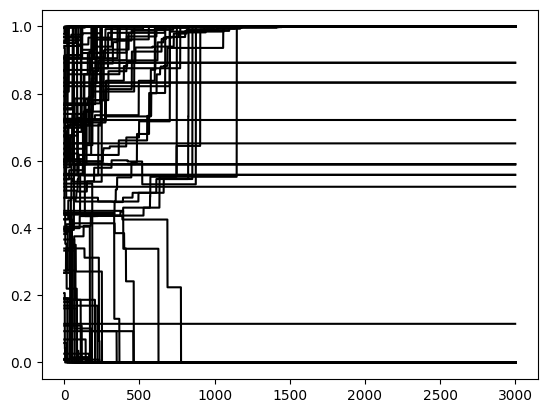

In [7]:
parameters = {
    "steps": 3000,
    "n_agents": 100,
    "opinion_weight_mode": 3,
    "tolerance": 0.3,
}
model = Model(parameters=parameters)

results = model.run()

for agent in model.agents:
    plt.plot(agent.opinion_history, color="black")

In [8]:
model.pop_maker.eval_affiliations()



______________________________________
Number of agents per location
______________________________________

               n_agents                                                    
                  count       mean       std   min   25%   50%    75%   max
location_class                                                             
Home               35.0   2.857143  1.417181   1.0   2.0   2.0   4.00   6.0
School              1.0   6.000000       NaN   6.0   6.0   6.0   6.00   6.0
Work                4.0  11.250000  0.500000  11.0  11.0  11.0  11.25  12.0


______________________________________
Number of affiliated locations per agent
______________________________________

count    100.000000
mean       1.510000
std        0.502418
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        2.000000
Name: n_affiliated_locations, dtype: float64
